In [191]:
import numpy as np
import pandas as pd
import nba_on_court as noc
import seaborn as sns
from sklearn.linear_model import RidgeCV
from nba_api.stats.endpoints import GameRotation, CommonPlayerInfo

pd.set_option('display.max_columns', 500)

This code uses data from a 3rd party source (see https://github.com/SCOREnetworkorg/sports-data-repository/blob/main/basketball/nba-rapm-data.qmd).

# Prepare the Data

First, load the data.

In [192]:
data: pd.DataFrame      = pd.read_csv('../../design_matrices/nba_2223_season_rapm_data.csv.gz', dtype={'game_id': str})
players: dict[int, str] = pd.read_csv('../../data/nba_2223_player_table.csv', index_col=0)['player_name'].to_dict()
games: pd.Series        = pd.unique(data['game_id'])

design  = data.drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)
data    = data[['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin']]
target  = data['margin']
weights = data['minutes']

data

,game_id,stint_id,n_pos,home_points,away_points,minutes,margin
0,0022200002,1,14,5,2,2.70,21.428571
1,0022200002,2,9,6,2,1.67,44.444444
2,0022200002,3,5,0,3,0.48,-60.000000
3,0022200002,4,5,5,1,0.78,80.000000
4,0022200002,5,9,3,6,1.52,-33.333333
...,...,...,...,...,...,...,...
32379,0022201229,18,16,8,13,3.44,-31.250000
32380,0022201229,19,11,7,10,2.45,-27.272727
32381,0022201229,20,21,13,17,4.30,-19.047619
32382,0022201229,21,12,7,8,3.53,-8.333333


Infer some features, namely the score-margin at the start of the stint and the home/away team.

In [193]:
data['end_score_margin']   = data['home_points'] - data['away_points']

# to be done at a later time
"""
data['start_score_margin'] = np.empty(len(data))
data['minutes_left']       = np.empty(len(data))
data['home_team']          = np.empty(len(data))
data['away_team']          = np.empty(len(data))

for game_id in :
    # infer the home team and away team
    game_data = GameRotation(game_id=game_id, league_id='00')
    home_team = game_data.home_team.get_data_frame()['TEAM_ID'].iloc[0]
    away_team = game_data.away_team.get_data_frame()['TEAM_ID'].iloc[0]

    data[data['game_id'] == game_id]
"""

"\ndata['start_score_margin'] = np.empty(len(data))\ndata['minutes_left']       = np.empty(len(data))\ndata['home_team']          = np.empty(len(data))\ndata['away_team']          = np.empty(len(data))\n\nfor game_id in :\n    # infer the home team and away team\n    game_data = GameRotation(game_id=game_id, league_id='00')\n    home_team = game_data.home_team.get_data_frame()['TEAM_ID'].iloc[0]\n    away_team = game_data.away_team.get_data_frame()['TEAM_ID'].iloc[0]\n\n    data[data['game_id'] == game_id]\n"

# Fit the Model

In [194]:
hypers = [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000]

model = RidgeCV( # Leave-One-Out CV based on MSE
    alphas=hypers,
    fit_intercept=False
).fit(design, target, sample_weight=weights)

In [195]:
results = pd.DataFrame({
    'Player ID': design.columns.astype(np.int32),
    'RAPM': model.coef_
})

results.insert(loc=1, column='Player Name', value=[
    players[player_id]
    for player_id in results['Player ID']
])

In [196]:
print(model.alpha_)

results.sort_values(by='RAPM', ascending=False).head(10)

1500


,Player ID,Player Name,RAPM
156,203954,Joel Embiid,3.011352
274,203999,Nikola Jokic,2.795283
2,203110,Draymond Green,2.455016
259,201950,Jrue Holiday,2.271931
273,203932,Aaron Gordon,2.197510
167,203076,Anthony Davis,2.189024
306,202695,Kawhi Leonard,2.146012
260,203507,Giannis Antetokounmpo,2.103321
103,1631132,Christian Koloko,2.020095
178,1628404,Josh Hart,1.999672


# Compute Average PM

Average PM is defined like so.

1. OnPM       = The Plus-Minus of the player while they were on the court.
2. OffPM      = The Plus-Minus while the player was off the court (in games where they were present at least once).
3. Average PM = (OnPM - OffPM) / Total Stints 

In [197]:
data

,game_id,stint_id,n_pos,home_points,away_points,minutes,margin,end_score_margin
0,0022200002,1,14,5,2,2.70,21.428571,3
1,0022200002,2,9,6,2,1.67,44.444444,4
2,0022200002,3,5,0,3,0.48,-60.000000,-3
3,0022200002,4,5,5,1,0.78,80.000000,4
4,0022200002,5,9,3,6,1.52,-33.333333,-3
...,...,...,...,...,...,...,...,...
32379,0022201229,18,16,8,13,3.44,-31.250000,-5
32380,0022201229,19,11,7,10,2.45,-27.272727,-3
32381,0022201229,20,21,13,17,4.30,-19.047619,-4
32382,0022201229,21,12,7,8,3.53,-8.333333,-1


In [198]:
results['Average PM'] = np.empty(len(results))

# calculate average PM. 
onpm         = np.zeros(len(results))
offpm        = np.zeros(len(results))
total_stints = np.zeros(len(results))

for game_id in games:
    bools: list[bool]     = data['game_id'] == game_id
    game_data, indicators = data[bools], design[bools]

    sign           = np.sign(indicators.sum(axis=0))
    on_indicators  = indicators
    off_indicators = ((~on_indicators.astype(bool)).astype(int)).mul(sign, axis=1) # in case we need to swap -1, 0 instead of 1, 0

    onpm         += on_indicators.mul(game_data['end_score_margin'], axis=0).sum(axis=0).to_numpy()
    offpm        += off_indicators.mul(game_data['end_score_margin'], axis=0).sum(axis=0).to_numpy()
    total_stints += len(game_data) * np.abs(sign)

average_pm = (onpm - offpm) / total_stints

for plr_id, plr_avg_pm in zip(design.columns.astype(int), average_pm): # the order of the players in the columns matches the order in average_pm
    results.loc[results['Player ID'] == plr_id, 'Average PM'] = plr_avg_pm

,Player ID,Player Name,RAPM,Average PM
0,201939,Stephen Curry,1.411566,0.173258
1,202691,Klay Thompson,0.180184,0.025368
2,203110,Draymond Green,2.455016,0.288675
3,203952,Andrew Wiggins,0.514009,0.176983
4,1626172,Kevon Looney,0.797916,0.071955
...,...,...,...,...
534,1628402,Frank Jackson,-0.013724,0.952381
535,1631495,Donovan Williams,0.095542,-0.243902
536,1630644,Mac McClung,0.262952,0.000000
537,1629663,Louis King,-0.089495,-0.964286


<Axes: xlabel='RAPM', ylabel='Average PM'>

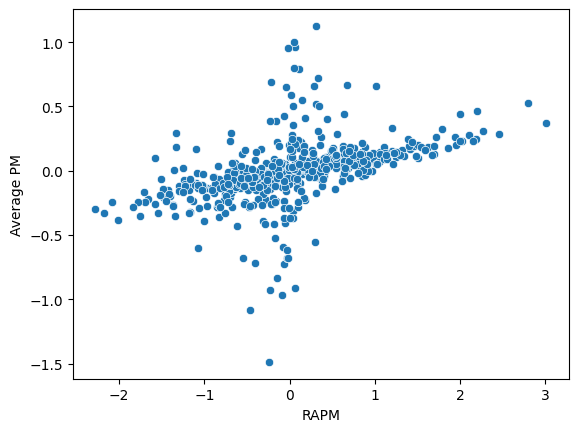

In [199]:
display(results)

sns.scatterplot(data=results, x='RAPM', y='Average PM')

In [200]:
results.sort_values(by='RAPM', ascending=False).to_csv('../../results/ryurko_results.csv')

In [203]:
results['Average PM'].corr(results['RAPM'])

0.45585430983992725